#### Import library : 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import spacy
import glob
from tqdm.notebook import tqdm
import re
import sys
import random
import os 
import pickle 
from IPython.display import clear_output
import pandas as pd
from collections import Counter, OrderedDict
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

NLP = spacy.load('en_core_web_sm')
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### GPU setting : 

In [3]:
use_gpu

True

In [4]:
device

device(type='cuda')

#### Data dir : 

In [5]:
data_dir = './'

#### Load & PreProcess on data : (txt , book , label)

In [6]:
df = pd.read_csv(data_dir + 'dataset.csv')

sent = df['text'].tolist()
label = df['label'].tolist()

#### Classes : 

In [7]:
len(np.unique(label))

5

In [8]:
label_name = np.unique(label)

label_dict = {}
for c in range(0 , len(label_name)) : 
    label_dict[label_name[c]] = c
label_dict

{'Modernism': 0,
 'Naturalism': 1,
 'Realism': 2,
 'Romanticism': 3,
 'Symbolism': 4}

#### Define a tokenizer :

In [9]:
def tokenizer(text):
    text = str(text).lower()
    text = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;]", " ", str(text))
    text = re.sub(r"[ ]+", " ", text)
    text = re.sub(r"\!+", "!", text)
    text = re.sub(r"\,+", ",", text)
    text = re.sub(r"\?+", "?", text)
    return [x.text for x in NLP.tokenizer(text) if x.text != " "]

In [10]:
sent[0]

'CHAPTER IIn the late summer of that year we lived in a house in a vil age that looked across the river and the plain to the mountains. In the bed of the  river there were pebbles and boulders, dry and white in the sun, and the water was clear and swiftly moving and blue in the channels. Troops went by the house and down the road and the dust they raised powdered the leaves of the trees. The trunks of the trees too were dusty and the leaves fel early that year and we saw the troops marching along the  road and the dust rising and leaves, stirred by the breeze, fal ing and the soldiers marching and afterward the road bare and white except for the leaves.'

In [11]:
' '.join(tokenizer(sent[0]))

'chapter iin the late summer of that year we lived in a house in a vil age that looked across the river and the plain to the mountains . in the bed of the river there were pebbles and boulders , dry and white in the sun , and the water was clear and swiftly moving and blue in the channels . troops went by the house and down the road and the dust they raised powdered the leaves of the trees . the trunks of the trees too were dusty and the leaves fel early that year and we saw the troops marching along the road and the dust rising and leaves , stirred by the breeze , fal ing and the soldiers marching and afterward the road bare and white except for the leaves .'

In [12]:
%%time
sent = list(map(lambda x : ' '.join(tokenizer(x)) , sent))
print('tokenizing data . ')

tokenizing data . 
Wall time: 15.3 s


#### Statistics : 

In [13]:
def cal_stats(corpus):
    
    lengths = []
    for sentence in tqdm(range(0 , len(corpus))) : 
        lengths.append(len(corpus[sentence].split(' ')))
    
    # compute stats
    total = sum(lengths)
    mean = np.mean(lengths)
    std = np.std(lengths)
    maximum = np.max(lengths)
    
    # print stats
    print('len sentence : ' , len(lengths))
    print('Total words in the corpus = {}\n'.format(total))
    print('maximum length : ' , maximum)
    print('Mean = {:.2f}'.format(mean))
    print('Std  = {:.2f}'.format(std))
    print('95% confidence interval = [{:.2f}, {:.2f}]'.format(np.max((mean-2*std , 0)), mean+2*std))
    
    # plot histogram
    plt.hist(lengths, bins=20)
    plt.show()

  0%|          | 0/32143 [00:00<?, ?it/s]

len sentence :  32143
Total words in the corpus = 3097207

maximum length :  4153
Mean = 96.36
Std  = 119.21
95% confidence interval = [0.00, 334.77]


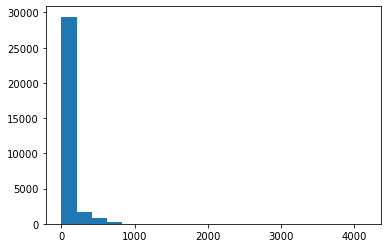

In [14]:
cal_stats(corpus = sent)

#### Split data : 

In [15]:
def splitData(texts , classes , split_ratio = .20) : 
    train , valid = [] , []
    for t in tqdm(range(0 , len(texts))) : 
        if random.uniform(0, 1) < split_ratio : 
            valid.append([texts[t] , classes[t]])
        else : 
            train.append([texts[t] , classes[t]])
    return train , valid

In [16]:
train , valid = splitData(sent , label)
len(train) , len(valid)

  0%|          | 0/32143 [00:00<?, ?it/s]

(25790, 6353)

#### Model setting : 

In [17]:
vocab_path = './vocab.pkl'

# parameters
max_len = 350
min_count = 1
batch_size = 32

#### Dataset and Dataloader : 

In [18]:
PAD = '<pad>'  # special symbol we use for padding text
UNK = '<unk>'  # special symbol we use for rare or unknown word

In [19]:
class Vocabulary(object):
    
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.count = 0
    
    def add_word(self, word):
        if not word in self.word2index:
            self.word2index[word] = self.count
            self.word2count[word] = 1
            self.index2word[self.count] = word
            self.count += 1
        else:
            self.word2count[word] += 1
    
    def add_sentence(self, sentence):
        for word in self.tokenizer(sentence):
            self.add_word(word)
            
    def __len__(self):
        return self.count

In [20]:
class TextClassificationDataset(Dataset):
    
    def __init__(self , data , tokenizer, 
                 vocab_path='./vocab.pkl', 
                 max_len=350, min_count=3):
        
        self.data = data
        self.vocab_path = vocab_path
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.min_count = min_count
        
        self.vocab = None
        
        self.classes = np.unique(list(map(lambda x : x[1] , self.data)))
        self.text = list(map(lambda x : x[0] , self.data))
        
        self.num_classes = len(self.classes)
        self.class_to_index = {}
        for c in range(0 , len(self.classes)) : 
            self.class_to_index[self.classes[c]] = c
        
        # build vocabulary from training and validation texts
        self.build_vocab()
        
    def __getitem__(self, index):
        text , class_idx = self.data[index]
        class_idx = self.class_to_index[class_idx]
        
        # tokenize the text file
        tokens = self.tokenizer(text.strip())
        
        # padding and trimming
        if len(tokens) < self.max_len:
            num_pads = self.max_len - len(tokens)
            tokens = [PAD] * num_pads + tokens
        elif len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
            
        # numericalizing
        ids = torch.LongTensor(self.max_len)
        for i, word in enumerate(tokens):
            if word not in self.vocab.word2index:
                ids[i] = self.vocab.word2index[UNK]  # unknown words
            elif word != PAD and self.vocab.word2count[word] < self.min_count:
                ids[i] = self.vocab.word2index[UNK]  # rare words
            else:
                ids[i] = self.vocab.word2index[word]
        
        return ids, class_idx
    
    def __len__(self):
        return len(self.text)
    
    def build_vocab(self):
        if not os.path.exists(self.vocab_path):
            vocab = Vocabulary(self.tokenizer)
            for line in tqdm(self.text , desc='Building Vocab'):
                vocab.add_sentence(line)

            # sort words by their frequencies
            words = [(0, PAD), (0, UNK)]
            words += sorted([(c, w) for w, c in vocab.word2count.items()], reverse=True)

            self.vocab = Vocabulary(self.tokenizer)
            for i, (count, word) in enumerate(words):
                self.vocab.word2index[word] = i
                self.vocab.word2count[word] = count
                self.vocab.index2word[i] = word
                self.vocab.count += 1

            pickle.dump(self.vocab, open(self.vocab_path, 'wb'))
        else:
            self.vocab = pickle.load(open(self.vocab_path, 'rb'))

In [21]:
train_ds = TextClassificationDataset(train, tokenizer, vocab_path, max_len, min_count)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TextClassificationDataset(valid, tokenizer, vocab_path, max_len, min_count)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

Building Vocab:   0%|          | 0/25790 [00:00<?, ?it/s]

In [22]:
len(train_ds) , len(valid_ds)

(25790, 6353)

In [23]:
next(iter(train_dl))

[tensor([[    0,     0,     0,  ...,    11,  1056,     3],
         [    0,     0,     0,  ...,  3465,    29,     3],
         [    0,     0,     0,  ...,    17,   228,     3],
         ...,
         [    0,     0,     0,  ...,    19,  6333,     3],
         [    0,     0,     0,  ..., 18767, 38726,     3],
         [    0,     0,     0,  ..., 49484,   617,    46]]),
 tensor([1, 2, 0, 1, 0, 1, 2, 4, 1, 0, 4, 0, 1, 2, 3, 3, 3, 0, 1, 1, 3, 1, 1, 0,
         4, 1, 3, 2, 1, 0, 2, 3])]

In [24]:
ids, label = train_ds[0]

print(label)
print(ids.numpy())

0
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0 

In [25]:
# convert back the sequence of integers into original text
print(' '.join([train_ds.vocab.index2word[i.item()] for i in ids]))

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [26]:
# print the original text
print(train[0][0])

chapter iin the late summer of that year we lived in a house in a vil age that looked across the river and the plain to the mountains . in the bed of the river there were pebbles and boulders , dry and white in the sun , and the water was clear and swiftly moving and blue in the channels . troops went by the house and down the road and the dust they raised powdered the leaves of the trees . the trunks of the trees too were dusty and the leaves fel early that year and we saw the troops marching along the road and the dust rising and leaves , stirred by the breeze , fal ing and the soldiers marching and afterward the road bare and white except for the leaves .


In [27]:
train_ds.class_to_index

{'Modernism': 0,
 'Naturalism': 1,
 'Realism': 2,
 'Romanticism': 3,
 'Symbolism': 4}

#### Vocabulary : 

In [28]:
vocab = train_ds.vocab
freqs = [(count, word) for (word, count) in vocab.word2count.items() if count >= min_count]
vocab_size = len(freqs) + 2  # for PAD and UNK tokens
print(f'Vocab size = {vocab_size}')

print('\nMost common words:')
for c, w in sorted(freqs, reverse=True)[:10]:
    print(f'{w}: {c}')

Vocab size = 113271

Most common words:
,: 162494
.: 119929
the: 96779
and: 64198
to: 54351
of: 51963
a: 46037
i: 45442
in: 33746
he: 33465


In [29]:
vocab_size = 2 + len([w for (w, c) in train_ds.vocab.word2count.items() if c >= 1])
print(vocab_size)

113271


#### Load pre-trained word wectors (fasttext = https://fasttext.cc/docs/en/crawl-vectors.html) : 

In [30]:
class WordVector(object):
    def __init__(self, lang, filename):
        " Create an instance of word vecor class."
        self.lang = lang
        self.word_vectors = pickle.load(open(filename, 'rb'))
        self.vector_size = len(self.word_vectors['</s>'])
        self.mean_vector = None
        self.stddev = None
        
    def __len__(self):
        return len(self.word_vectors)
    
    def __getitem__(self, word):
        return self.get_word_vector(word)
        
    def get_words(self):
        return [w for w in self.word_vectors]
    
    def mean(self):
        if self.mean_vector is None:
            vectors = np.stack([v for _, v in self.word_vectors.items()], axis=0)
            self.mean_vector = np.mean(vectors, axis=0)
        return self.mean_vector
    
    def std(self):
        if self.stddev is None:
            vectors = np.stack([v for _, v in self.word_vectors.items()], axis=0)
            self.stddev = np.std(vectors)
        return self.stddev
    
    def get_word_vector(self, word):
        return self.word_vectors.get(word, self.mean() + np.random.normal(scale=self.std(), size=(self.vector_size,)))
        
    def get_word_vectors(self, words):
        return [self.get_word_vector(w) for w in words]
        
    def most_similar(self, word, n=10):
        v = self.get_word_vector(word)
        V = np.stack([v for _, v in self.word_vectors.items()], axis=0)
        dist = V - v
        idxes = np.argsort(np.sum(dist * dist, axis=1))[:n]
        
        result = []
        for i, w in enumerate(self.word_vectors.keys()):
            if i in idxes:
                result += [w]
        return result

#### vector file to pkl : 

In [31]:
lang = 'en'
fname = f'./wiki.{lang}.vec'
pkl_fname = f'./wiki.{lang}.pkl'

word_vecs = defaultdict()
with open(fname, encoding='utf8') as f:
    for i, line in enumerate(tqdm(f, desc='reading')):
        if i == 0: continue
        tokens = line.strip().split(' ')
        if len(tokens) != 301: continue
        word = tokens[0]
        wv = np.array([float(x) for x in tokens[1:]])
        word_vecs[word] = wv
        
pickle.dump(word_vecs, open(pkl_fname, 'wb'))

reading: 0it [00:00, ?it/s]

#### Load pkl file : 

In [32]:
wvecs_filename = f'./wiki.{lang}.pkl'
wvecs = WordVector(lang, wvecs_filename)

print(len(wvecs))

111018


#### Embeding vocab : 

In [33]:
def get_embeddings(vocab, wv):
    num_vocabs, embed_sz = len(vocab), wv.vector_size
    emb = torch.zeros(num_vocabs, embed_sz)
    for idx in tqdm(range(num_vocabs)):
        emb[idx] = torch.from_numpy(wv[vocab.index2word[idx]])
    return emb

In [34]:
embeddings = get_embeddings(vocab, wvecs)

  0%|          | 0/113271 [00:00<?, ?it/s]

In [35]:
embeddings.size()

torch.Size([113271, 300])

#### LSTM with Attention mechanism :

In [69]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )
    
    def forward(self, encoder_outputs):
        # encoder_outputs = [batch size, sent len, hid dim]
        energy = self.projection(encoder_outputs)
        # energy = [batch size, sent len, 1]
        weights = F.softmax(energy.squeeze(-1), dim=1)
        # weights = [batch size, sent len]
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        # outputs = [batch size, hid dim]
        return outputs, weights

    
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout , emb = None):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embed_size
        self.num_layers = n_layers
        
        # emb ####################################
        if emb is not None:
            assert emb.size(0) == vocab_size, 'Invalid embeddings!'
            self.embedding_dim = emb.size(1)        
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        if emb is not None:
            self.embedding.weight.data = emb
        # emb ####################################

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, 
                            dropout= 0 if n_layers < 2 else dropout)
        self.attention = SelfAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x = [sent len, batch size]
        embedded = self.embedding(x)
        # embedded = [sent len, batch size, emb dim]
        output, (hidden, cell) = self.lstm(embedded)
        # use 'batch_first' if you want batch size to be the 1st para
        # output = [sent len, batch size, hid dim*num directions]
        output = output[:, :, :self.hidden_dim] + output[:, :, self.hidden_dim:]
        # output = [sent len, batch size, hid dim]
        ouput = output.permute(1, 0, 2)
        # ouput = [batch size, sent len, hid dim]
        new_embed, weights = self.attention(ouput)
        # new_embed = [batch size, hid dim]
        # weights = [batch size, sent len]
        new_embed = self.dropout(new_embed)
        return self.fc(new_embed)

#### Train functions : 

In [80]:
def detach(x):
    """ Detach hidden states from their history."""
    return Variable(x.data) if type(x) == Variable else tuple(detach(v) for v in x)

def train_step(model, train_dl, criterion, optimizer, device):
    model.train()
    
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    
    for i, (train_inputs, train_labels) in tqdm(enumerate(train_dl), 
                                                         desc='Training', 
                                                         total=len(train_dl)):
        
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
        if len(train_labels) < train_dl.batch_size: continue
        
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        model.zero_grad()
        output = model(train_inputs.t())
        
        loss = criterion(output, train_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)        
        optimizer.step()

        # calculate training acc and loss
        _, predicted = torch.max(output, 1)
        total_acc += (predicted == train_labels).sum()
        total_loss += loss.item()
        total += len(train_labels)
        
    return total_loss / total, total_acc / total


def validate_step(model, valid_dl, criterion, device):
    model.eval()
        
    total_acc = 0.0
    total_loss = 0.0
    total = 0.0
    
    with torch.no_grad():
        for i, (test_inputs, test_labels) in tqdm(enumerate(valid_dl), 
                                                           desc='Validation', 
                                                           total=len(valid_dl)):

            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            if len(test_labels) < valid_dl.batch_size: continue

            output = model(test_inputs.t())
            loss = criterion(output, test_labels)

            # calculate testing acc and loss
            _, predicted = torch.max(output, 1)
            total_acc += (predicted == test_labels).sum()
            total_loss += loss.item()
            total += len(test_labels)
        
    return total_loss / total, total_acc / total


def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs):
    max_len, min_count = train_dl.dataset.max_len, train_dl.dataset.min_count
    
    train_hist, valid_hist = [], []
    best_acc, best_wts = 0.0, None
    
    report = ""

    for epoch in range(num_epochs):
        if epoch > 0: 
            clear_output(wait=True)
            print(report)

        ## perform one epoch of training and validation
        trn_loss, trn_acc = train_step(model, train_dl, criterion, optimizer, device)
        val_loss, val_acc = validate_step(model, valid_dl, criterion, device)
        scheduler.step()

        train_hist += [(trn_loss, trn_acc.item())]
        valid_hist += [(val_loss, val_acc.item())]

        # save weights
        if val_acc > best_acc:
            best_acc = val_acc
            best_wts = model.state_dict().copy()
            torch.save(best_wts, './TextClassificaition.pth')

        report += f'[Epoch: {epoch + 1:2d}/{num_epochs:2d}] | Training Loss: {trn_loss:.4f} | Testing Loss: {val_loss:.4f} | Training Acc: {trn_acc*100:.2f} | Testing Acc: {val_acc*100:.2f}\n'

    model.load_state_dict(best_wts)
    return train_hist, valid_hist

def prediction(model, inp , criterion , device , tokenizer , max_len , vocab):
    model.eval()
    
     # tokenize the text file
    print(inp)
    tokens = tokenizer(inp.strip())

    # padding and trimming
    if len(tokens) < max_len:
        num_pads = max_len - len(tokens)
        tokens = [PAD] * num_pads + tokens
    elif len(tokens) > max_len:
        tokens = tokens[:max_len]
    print(tokens)
    
    # numericalizing
    ids = torch.LongTensor(max_len)
    for i, word in enumerate(tokens):
        if word not in vocab.word2index:
            ids[i] = vocab.word2index[UNK]  # unknown words
        elif word != PAD and vocab.word2count[word] < min_count:
            ids[i] = vocab.word2index[UNK]  # rare words
        else:
            ids[i] = vocab.word2index[word]
    ids = ids.unsqueeze(0).to(device)
    print(ids)
    
    with torch.no_grad():
        output = model(ids.t())
        _, predicted = torch.max(output, 1)
        
    return predicted

#### Model setting : 

In [71]:
# LSTM parameters
embed_size = 100
hidden_size = 256
num_layers = 1

# training parameters
lr = 0.001
num_epochs = 10

In [74]:
model = AttentionLSTM(vocab_size, embed_size, hidden_size, 
                      output_dim=train_ds.num_classes, 
                      n_layers=num_layers, bidirectional=True, dropout=0.5 , emb = embeddings)


model = model.to(device)
model

AttentionLSTM(
  (embedding): Embedding(113271, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (attention): SelfAttention(
    (projection): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

#### Loss function and optimizer : 

In [75]:
criterion = nn.CrossEntropyLoss().to(device)
criterion = criterion.to(device)
    
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.7, 0.99))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

#### Training : 

In [76]:
train_hist, valid_hist = train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs)

[Epoch:  1/10] | Training Loss: 0.0243 | Testing Loss: 0.0112 | Training Acc: 70.06 | Testing Acc: 86.84
[Epoch:  2/10] | Training Loss: 0.0072 | Testing Loss: 0.0100 | Training Acc: 92.17 | Testing Acc: 88.76
[Epoch:  3/10] | Training Loss: 0.0030 | Testing Loss: 0.0110 | Training Acc: 96.77 | Testing Acc: 89.88
[Epoch:  4/10] | Training Loss: 0.0013 | Testing Loss: 0.0129 | Training Acc: 98.70 | Testing Acc: 90.09
[Epoch:  5/10] | Training Loss: 0.0005 | Testing Loss: 0.0160 | Training Acc: 99.51 | Testing Acc: 89.79
[Epoch:  6/10] | Training Loss: 0.0002 | Testing Loss: 0.0228 | Training Acc: 99.79 | Testing Acc: 88.54
[Epoch:  7/10] | Training Loss: 0.0001 | Testing Loss: 0.0232 | Training Acc: 99.92 | Testing Acc: 89.43
[Epoch:  8/10] | Training Loss: 0.0001 | Testing Loss: 0.0268 | Training Acc: 99.97 | Testing Acc: 88.75
[Epoch:  9/10] | Training Loss: 0.0001 | Testing Loss: 0.0278 | Training Acc: 99.97 | Testing Acc: 88.70



Training:   0%|          | 0/806 [00:00<?, ?it/s]

Validation:   0%|          | 0/199 [00:00<?, ?it/s]

In [77]:
train_loss = list(map(lambda x : x[0] , train_hist))
train_acc = list(map(lambda x : x[1] , train_hist))
valid_loss = list(map(lambda x : x[0] , valid_hist))
valid_acc = list(map(lambda x : x[1] , valid_hist))

#### Plot accuracy : 

In [78]:
model.load_state_dict(torch.load( "./TextClassificaition.pth"))

<All keys matched successfully>

In [89]:
prediction(model, valid[6300][0] , criterion , device , tokenizer , max_len , vocab)

angry as i was , as we all were , i was tempted to laugh whenever he opened his mouth . the transition from libertine to prig was so complete .
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

tensor([4], device='cuda:0')

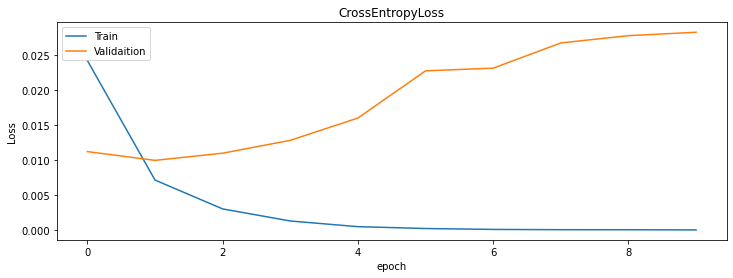

In [90]:
plt.figure(figsize=(12, 4))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('CrossEntropyLoss')
plt.legend(['Train' , 'Validaition'])
plt.show()

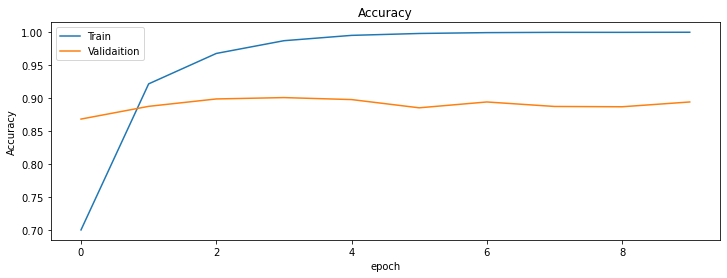

In [91]:
plt.figure(figsize=(12, 4))
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(['Train' , 'Validaition'])
plt.show()